In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/ssa_2021_access.csv")
IND_u= pd.read_csv('../Datasets/ssa_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    21216
1     3821
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,2,2.0,1,2
1,2,3.0,3,4
2,2,2.0,1,2
3,1,1.0,1,3
4,2,1.0,2,5
...,...,...,...,...
25032,2,1.0,2,4
25033,1,1.0,2,2
25034,1,1.0,1,5
25035,2,3.0,2,4


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,2497,2294,2294,2147,1810
2,1626,1816,2237,2852,4128
3,85,62,96,205,888


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,-0.184496,-0.983890,0.000612,0.122409,0.197689,-0.258786,0.067902,-0.046227,-0.054132
1,-0.715089,-0.042199,-0.041139,-0.206764,-0.455772,0.232221,-0.047264,-0.024166,-0.018510
2,-1.027380,0.629412,0.088970,0.182999,0.247875,-0.171297,0.007392,-0.032252,-0.018638
3,-1.027380,0.629412,0.088970,0.182999,0.247875,-0.171297,0.007392,-0.032252,-0.018638
4,-0.184496,-0.983890,0.000612,0.122409,0.197689,-0.258786,0.067902,-0.046227,-0.054132
...,...,...,...,...,...,...,...,...,...
25032,-0.715089,-0.042199,-0.041139,-0.206764,-0.455772,0.232221,-0.047264,-0.024166,-0.018510
25033,-0.401593,-0.438960,-0.072878,0.023115,-0.524625,-0.547447,0.189156,-0.001542,-0.011338
25034,-0.713884,0.232652,0.057231,0.412878,0.179022,-0.950965,0.243812,-0.009629,-0.011466
25035,-0.401593,-0.438960,-0.072878,0.023115,-0.524625,-0.547447,0.189156,-0.001542,-0.011338


In [9]:
mca_u = prince.MCA(n_components=28)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28
0,0.025028,-0.305044,0.288758,0.556320,-0.019481,0.091238,-0.083850,-0.187153,-0.116105,0.211870,...,-0.186865,0.025163,0.146768,-0.096422,0.007117,0.049159,-0.006128,0.010851,-0.074516,0.072536
1,-0.513587,0.079729,-0.112351,0.770474,-0.072042,0.092684,-0.110229,0.036180,-0.009271,-0.085404,...,0.073967,-0.046574,0.009794,-0.014852,0.030892,0.030320,0.021591,0.008796,-0.012159,-0.034798
2,-0.569817,-0.021499,-0.112268,-0.167895,-0.111289,0.271104,-0.260479,0.006089,0.024524,-0.204942,...,-0.229699,0.114437,0.043110,-0.016336,-0.065750,-0.056198,0.011541,-0.039296,-0.040130,0.003196
3,-0.644008,0.033659,-0.235433,0.016260,0.071028,-0.129123,0.060395,-0.067224,-0.053131,0.059883,...,-0.005782,-0.024211,0.059759,-0.037896,0.155292,0.119851,-0.077386,-0.148697,0.209035,-0.279153
4,-0.018248,-0.391002,-0.034417,-0.178523,0.300647,-0.182607,0.093434,-0.256403,-0.166378,0.324440,...,0.057587,-0.187658,0.243487,0.681647,0.134101,0.073677,-0.104361,-0.032483,-0.093970,0.036597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25032,-0.215442,-0.461648,0.116876,-0.291031,0.322911,0.110297,-0.139239,-0.288881,-0.082482,0.198909,...,-0.053290,0.058677,-0.181804,-0.157305,0.151528,0.127871,0.000810,-0.045928,0.215126,-0.244377
25033,-0.489608,-0.139080,0.018886,-0.090909,-0.130065,-0.320962,0.295496,0.242437,0.099735,-0.178141,...,0.031922,-0.039907,0.046330,0.040468,0.134967,0.116131,-0.093249,-0.118672,0.206626,-0.283881
25034,-0.429762,-0.289554,0.007431,-0.273921,0.197680,0.292913,-0.297736,-0.151886,-0.037468,-0.005968,...,-0.008279,0.070254,-0.450045,-0.047377,-0.041713,-0.054954,0.072291,0.068377,0.093344,-0.067776
25035,-0.744057,0.122635,-0.310146,0.021001,0.047754,-0.033075,-0.028861,0.000498,-0.024366,-0.058897,...,0.008963,0.002251,-0.003530,0.003305,0.011149,0.006100,-0.002689,-0.010497,0.022322,-0.043997


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,female,age,educ,inc_q
0,-0.184496,-0.983890,0.000612,0.122409,0.197689,-0.258786,0.067902,-0.046227,-0.054132,0.025028,...,0.007117,0.049159,-0.006128,0.010851,-0.074516,0.072536,2,2.0,1,2
1,-0.715089,-0.042199,-0.041139,-0.206764,-0.455772,0.232221,-0.047264,-0.024166,-0.018510,-0.513587,...,0.030892,0.030320,0.021591,0.008796,-0.012159,-0.034798,2,3.0,3,4
2,-1.027380,0.629412,0.088970,0.182999,0.247875,-0.171297,0.007392,-0.032252,-0.018638,-0.569817,...,-0.065750,-0.056198,0.011541,-0.039296,-0.040130,0.003196,2,2.0,1,2
3,-1.027380,0.629412,0.088970,0.182999,0.247875,-0.171297,0.007392,-0.032252,-0.018638,-0.644008,...,0.155292,0.119851,-0.077386,-0.148697,0.209035,-0.279153,1,1.0,1,3
4,-0.184496,-0.983890,0.000612,0.122409,0.197689,-0.258786,0.067902,-0.046227,-0.054132,-0.018248,...,0.134101,0.073677,-0.104361,-0.032483,-0.093970,0.036597,2,1.0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25032,-0.715089,-0.042199,-0.041139,-0.206764,-0.455772,0.232221,-0.047264,-0.024166,-0.018510,-0.215442,...,0.151528,0.127871,0.000810,-0.045928,0.215126,-0.244377,2,1.0,2,4
25033,-0.401593,-0.438960,-0.072878,0.023115,-0.524625,-0.547447,0.189156,-0.001542,-0.011338,-0.489608,...,0.134967,0.116131,-0.093249,-0.118672,0.206626,-0.283881,1,1.0,2,2
25034,-0.713884,0.232652,0.057231,0.412878,0.179022,-0.950965,0.243812,-0.009629,-0.011466,-0.429762,...,-0.041713,-0.054954,0.072291,0.068377,0.093344,-0.067776,1,1.0,1,5
25035,-0.401593,-0.438960,-0.072878,0.023115,-0.524625,-0.547447,0.189156,-0.001542,-0.011338,-0.744057,...,0.011149,0.006100,-0.002689,-0.010497,0.022322,-0.043997,2,3.0,2,4


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .42, 1:.52}], 
              'C': [100]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 100, 'class_weight': {0: 0.42, 1: 0.52}}
Best score: 0.8550990090850437


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_)
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9870014604407411
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4197
           1       0.83      0.90      0.86       811

    accuracy                           0.95      5008
   macro avg       0.90      0.93      0.92      5008
weighted avg       0.96      0.95      0.95      5008



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [15]:
acc= accuracy_score(y_test, y_pred)
pre= precision_score(y_test, y_pred)
rec= recall_score(y_test, y_pred)
f_1= f1_score(y_test, y_pred)
acc, rec, pre, f_1, auc1

(0.9530750798722045,
 0.8951911220715166,
 0.8287671232876712,
 0.8606994665085952,
 0.9870014604407411)

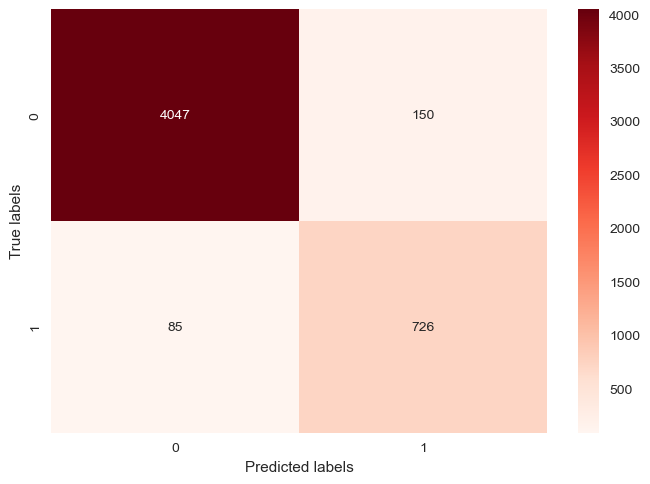

In [16]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [17]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

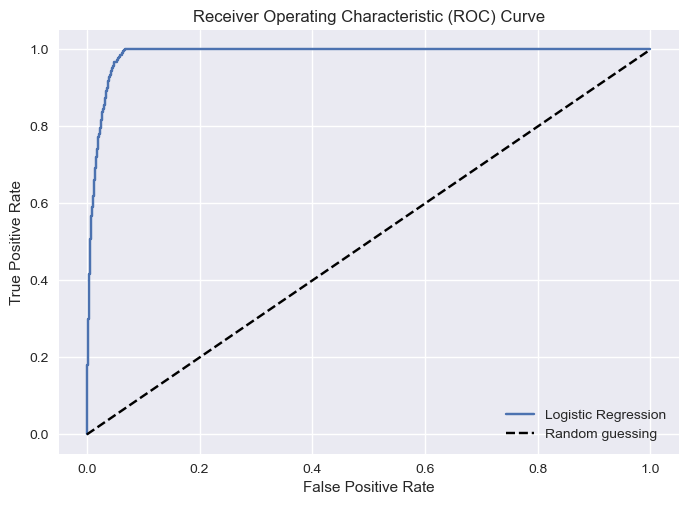

In [18]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [19]:
weights= [i for i in np.linspace(0, 1,100)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(84,85)],
    'max_depth': [7],
    'min_samples_split': [i for i in range(10,11)],
    'min_samples_leaf': [i for i in range(2,3)],
    'max_features': ['sqrt'],
    'class_weight': [{0:.28 , 1: .57}]
}
rf = RandomForestClassifier(random_state= 42)

In [20]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.28, 1: 0.57}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 84}
Best score: 0.793494393645268


In [21]:
grid_search_rf.best_params_

{'class_weight': {0: 0.28, 1: 0.57},
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 84}

In [22]:
auc2 = roc_auc_score(y_test, proba[:,1])
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9746038727092659
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4197
           1       0.75      0.81      0.78       811

    accuracy                           0.93      5008
   macro avg       0.86      0.88      0.87      5008
weighted avg       0.93      0.93      0.93      5008



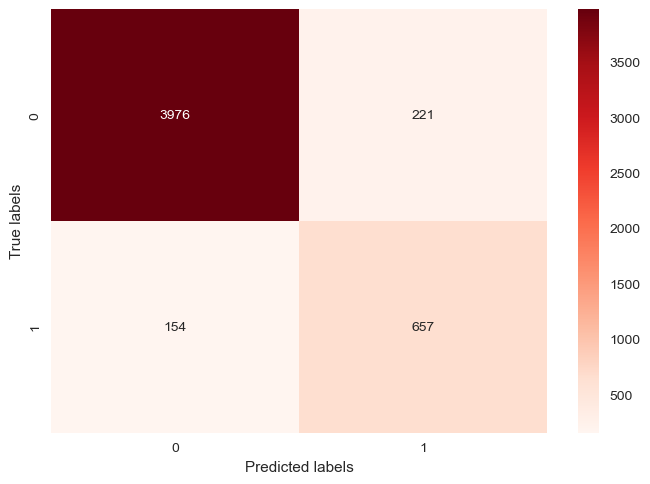

In [23]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [24]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

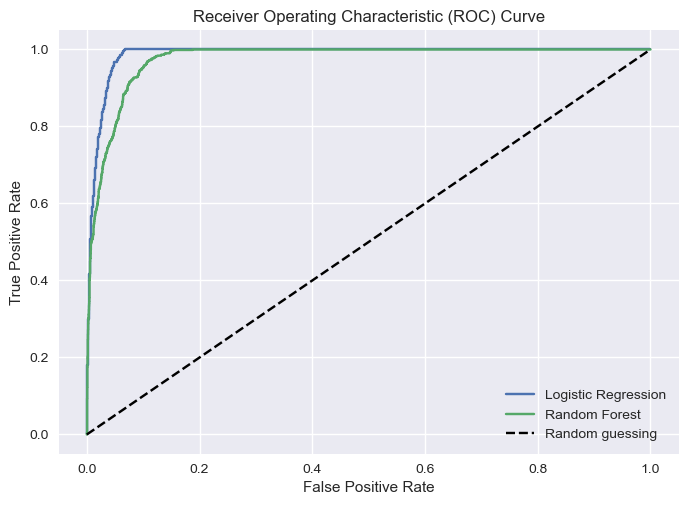

In [25]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [26]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [27]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.8357179475678824


In [28]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [29]:
auc3 = roc_auc_score(y_test, y_)
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9830652333135612
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4197
           1       0.84      0.81      0.82       811

    accuracy                           0.94      5008
   macro avg       0.90      0.89      0.90      5008
weighted avg       0.94      0.94      0.94      5008



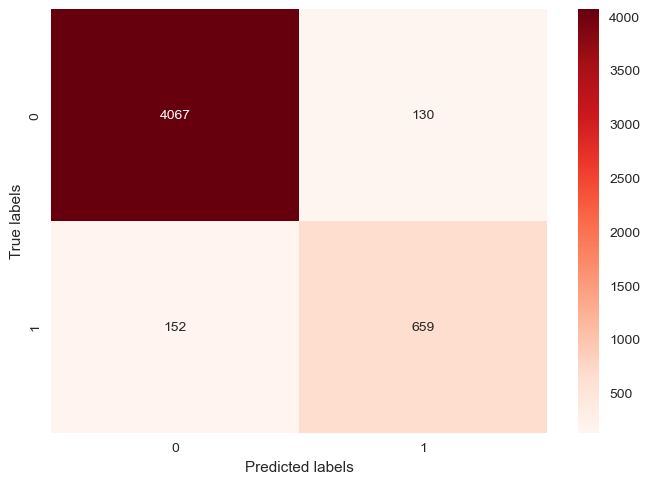

In [30]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [31]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

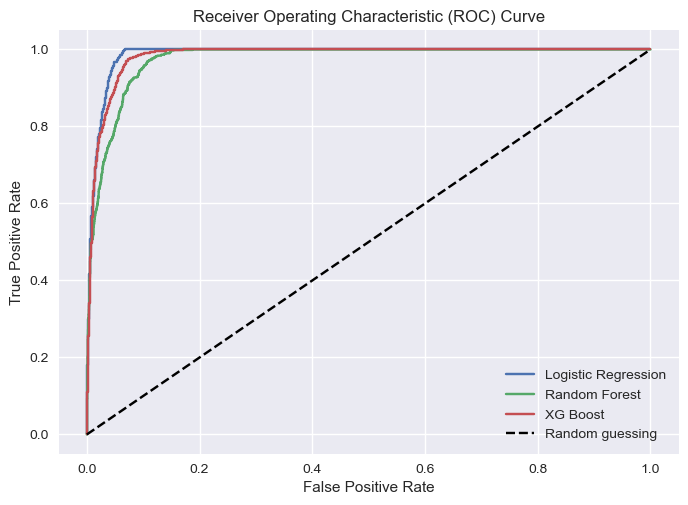

In [32]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [33]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [35]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
501/501 [==============================] - 0s 588us/step - loss: 0.1790 - precision: 0.8111 - recall: 0.6470 - val_loss: 0.1299 - val_precision: 0.7280 - val_recall: 0.9331
Epoch 2/50
501/501 [==============================] - 0s 469us/step - loss: 0.0983 - precision: 0.8267 - recall: 0.8751 - val_loss: 0.1075 - val_precision: 0.7678 - val_recall: 0.8908
Epoch 3/50
501/501 [==============================] - 0s 441us/step - loss: 0.0932 - precision: 0.8393 - recall: 0.8812 - val_loss: 0.1067 - val_precision: 0.7890 - val_recall: 0.8556
Epoch 4/50
501/501 [==============================] - 0s 440us/step - loss: 0.0925 - precision: 0.8355 - recall: 0.8796 - val_loss: 0.1088 - val_precision: 0.7749 - val_recall: 0.8908
Epoch 5/50
501/501 [==============================] - 0s 439us/step - loss: 0.0888 - precision: 0.8454 - recall: 0.8845 - val_loss: 0.1063 - val_precision: 0.7919 - val_recall: 0.8574
Epoch 6/50
501/501 [==============================] - 0s 436us/step - loss: 0.08

501/501 [==============================] - 0s 435us/step - loss: 0.0497 - precision: 0.9252 - recall: 0.9320 - val_loss: 0.1664 - val_precision: 0.7801 - val_recall: 0.7993
Epoch 46/50
501/501 [==============================] - 0s 430us/step - loss: 0.0485 - precision: 0.9192 - recall: 0.9361 - val_loss: 0.1731 - val_precision: 0.7712 - val_recall: 0.8011
Epoch 47/50
501/501 [==============================] - 0s 430us/step - loss: 0.0467 - precision: 0.9308 - recall: 0.9369 - val_loss: 0.1782 - val_precision: 0.7715 - val_recall: 0.8204
Epoch 48/50
501/501 [==============================] - 0s 429us/step - loss: 0.0471 - precision: 0.9266 - recall: 0.9357 - val_loss: 0.1846 - val_precision: 0.7774 - val_recall: 0.8363
Epoch 49/50
501/501 [==============================] - 0s 429us/step - loss: 0.0461 - precision: 0.9288 - recall: 0.9353 - val_loss: 0.1870 - val_precision: 0.7615 - val_recall: 0.8486
Epoch 50/50
501/501 [==============================] - 0s 430us/step - loss: 0.0445 - p

In [36]:
y_ = ann.predict(X_test)

157/157 [==============================] - 0s 243us/step


In [37]:
y_= y_.reshape(y_.shape[0],)

In [38]:
y_pred= np.array([round(i) for i in y_])

In [39]:
auc4 = roc_auc_score(y_test, y_)
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9814302800397325
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4197
           1       0.82      0.83      0.82       811

    accuracy                           0.94      5008
   macro avg       0.89      0.90      0.90      5008
weighted avg       0.94      0.94      0.94      5008



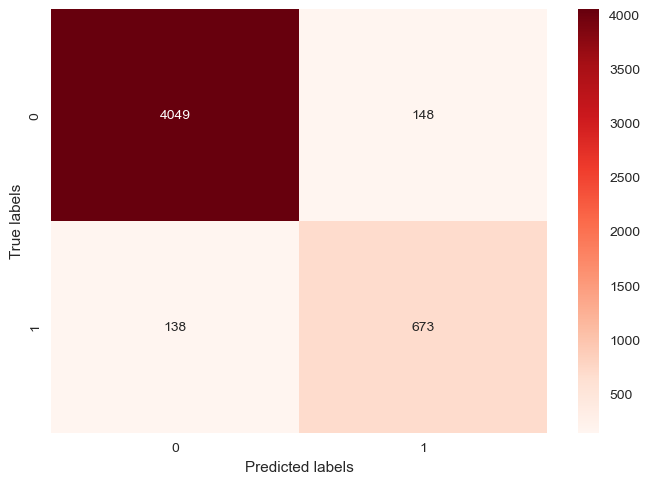

In [40]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [41]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

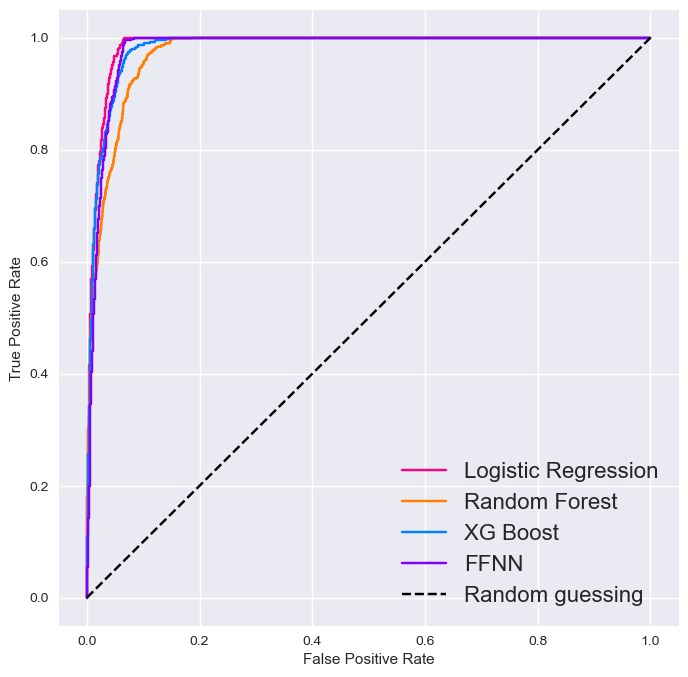

In [42]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_ken.png")
plt.show()

## Model Evaluations

In [43]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9531 & 0.9251 & 0.9437 & 0.9429 \\
   Recall & 0.8952 & 0.8101 & 0.8126 & 0.8298 \\
Precision & 0.8288 & 0.7483 & 0.8352 & 0.8197 \\
 F1-Score & 0.8607 & 0.7780 & 0.8238 & 0.8248 \\
      AUC & 0.9870 & 0.9746 & 0.9831 & 0.9814 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [44]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [45]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [46]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-2.189430758875275, 3.9252337110244606, -0.13167869616567282)

In [47]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [48]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.3365273880258133)

In [49]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-1.17751008417483, 2.339390060777836, -0.05157518951009714)

In [50]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [51]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [52]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [53]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

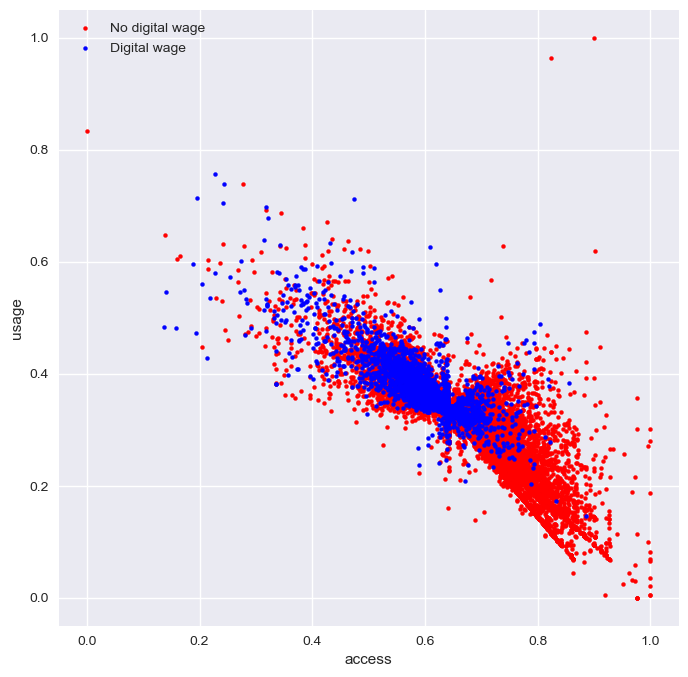

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.25,1.05])
#plt.ylim([-0.05,.75])
plt.savefig('../../images/find_ken')
plt.show()

In [55]:
IND_fin['access'].describe()

count    25037.000000
mean         0.663473
std          0.081042
min          0.000000
25%          0.616793
50%          0.667233
75%          0.706558
max          1.000000
Name: access, dtype: float64

In [56]:
IND_fin['usage'].describe()

count    25037.000000
mean         0.320150
std          0.065670
min          0.000000
25%          0.289096
50%          0.324477
75%          0.354805
max          1.000000
Name: usage, dtype: float64

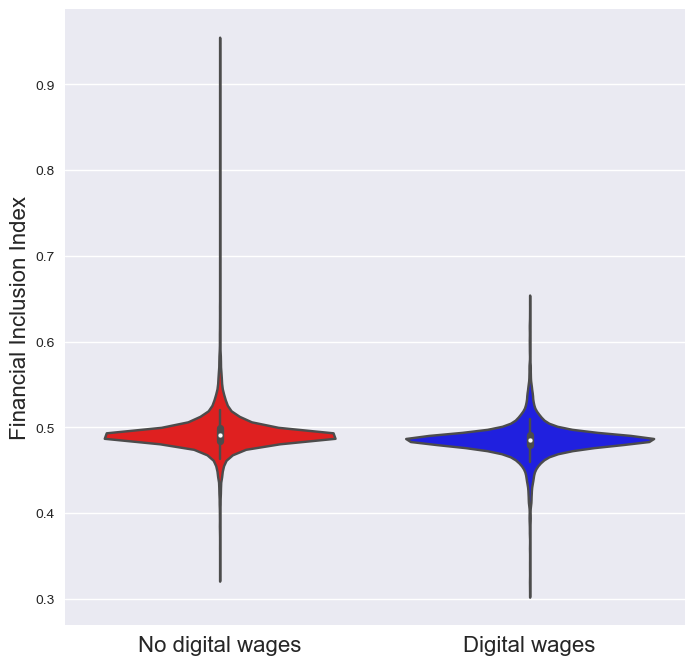

In [57]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_ken')

# Show the plot
plt.show()

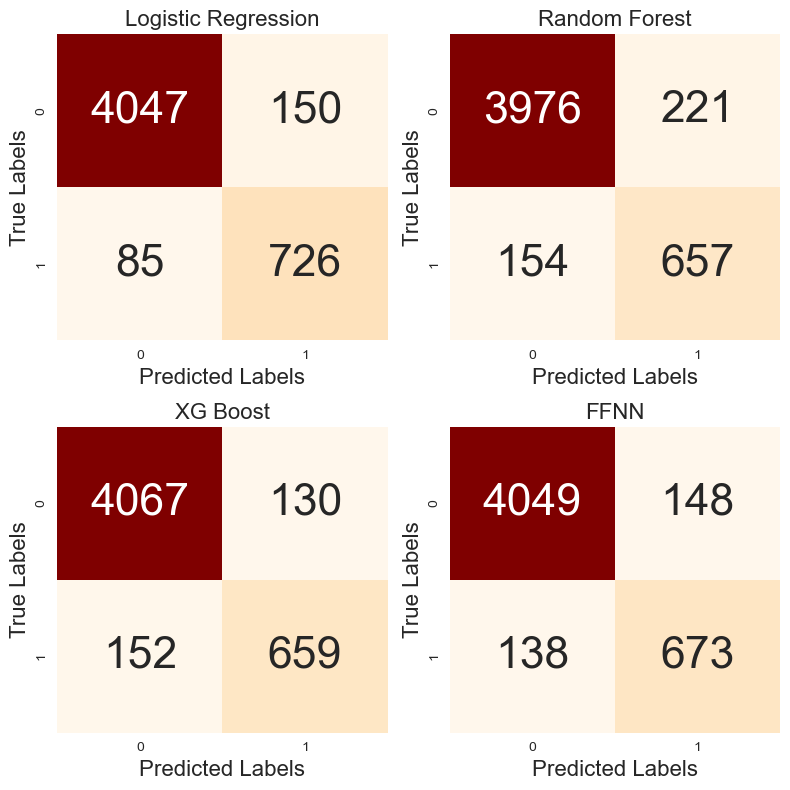

[CV] END .............C=100, class_weight={0: 0.42, 1: 0.52}; total time=   0.5s
[CV] END .............C=100, class_weight={0: 0.42, 1: 0.52}; total time=   0.4s
[CV] END class_weight={0: 0.28, 1: 0.57}, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=84; total time=   2.0s
[CV] END class_weight={0: 0.28, 1: 0.57}, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=84; total time=   2.0s
[CV] END class_weight={0: 0.28, 1: 0.57}, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=84; total time=   1.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=376, reg_alpha=0.5, reg_lambda=0.1, subsample=0.5; total time=   2.5s
[CV] END .............C=100, class_weight={0: 0.42, 1: 0.52}; total time=   0.5s
[CV] END class_weight={0: 0.28, 1: 0.57}, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=84; total time=   2.0s
[C

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="OrRd", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_ssa.png')
# Display the plot
plt.show()

## Feature Importance

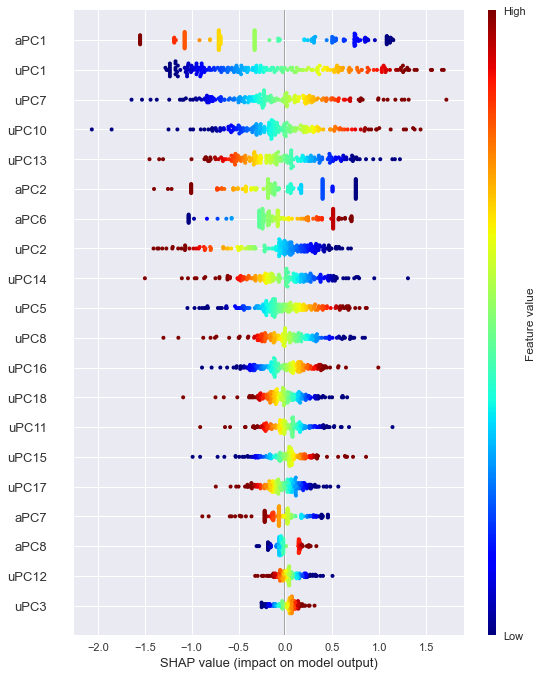

In [66]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [59]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

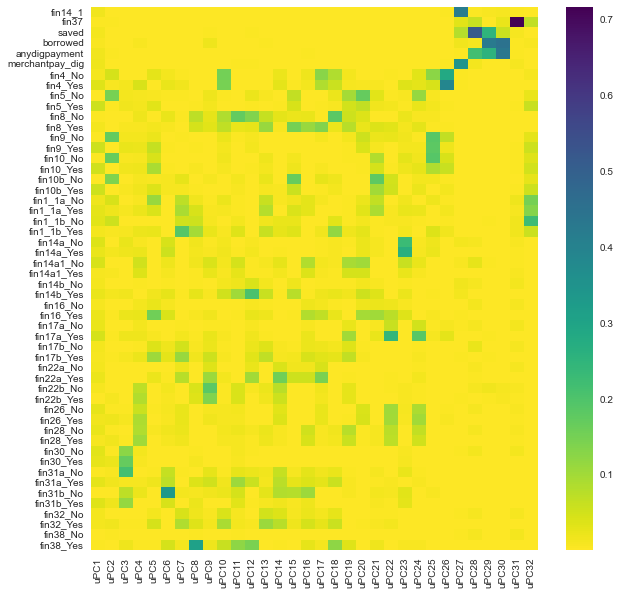

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_ken.png')
plt.show()

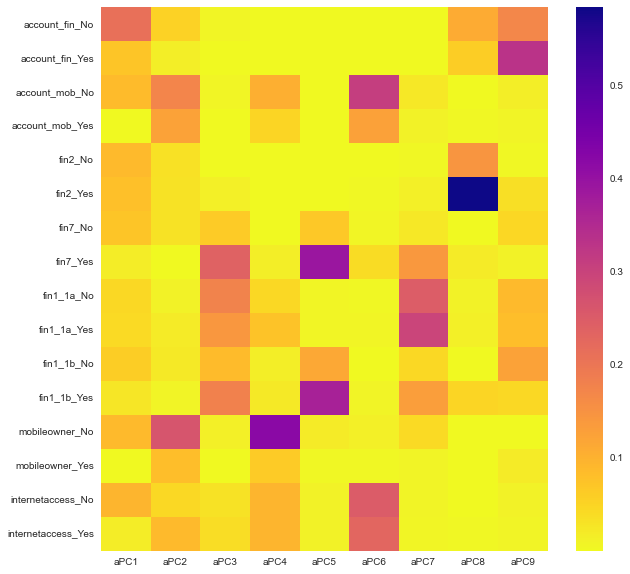

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_ken.png')
plt.show()

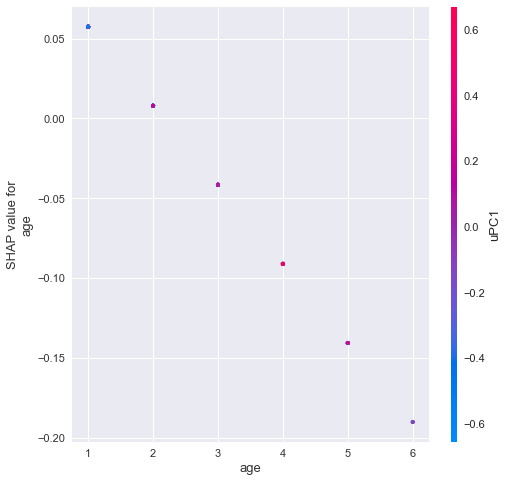

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

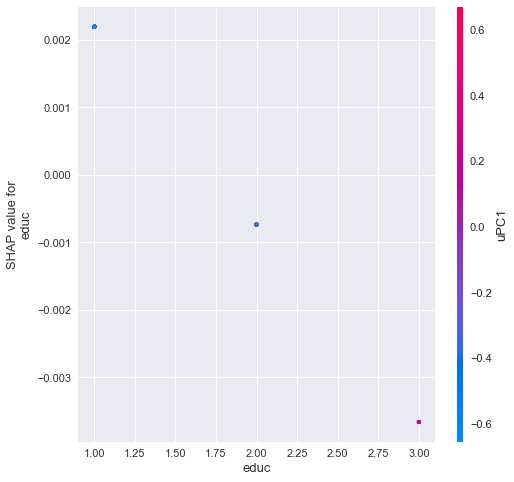

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

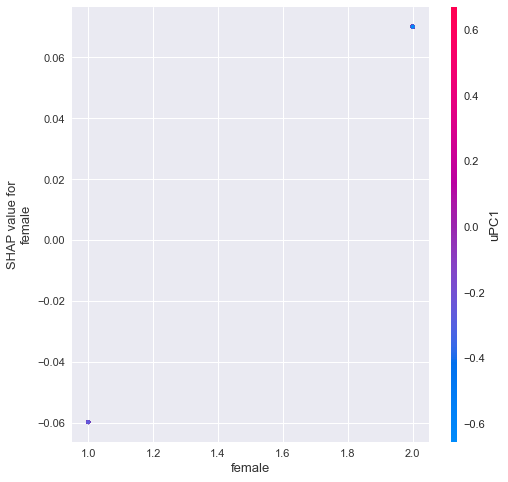

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

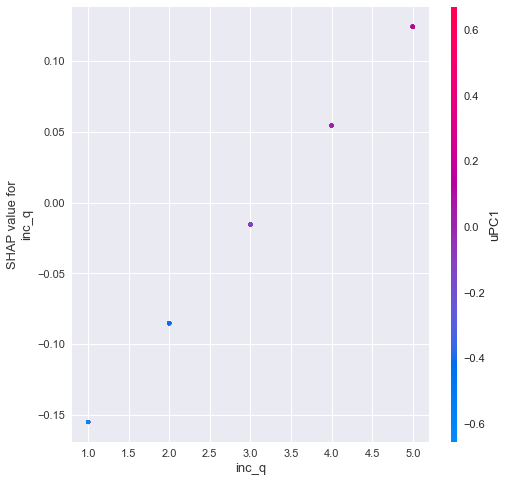

In [65]:
ig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()